
# Unified Silhouette Pipeline (HDR Coverage + Point-Fraction)

This notebook unifies both pipelines into one workflow with shared preprocessing, shared grid utilities, a common **ShapeProduct** interface, and a single metrics/plotting stack.  
You can toggle which variants to run and export figures/metrics side-by-side.

**Variants**
- `hdr` — *coverage mass on a float density field* (bootstrapped & smoothed) → mass-threshold isocontour.
- `point_fraction` — *densest subset of points (top p% by KDE)* → rasterized binary mask → contour.

> Semantics are preserved (mass vs densest-subset). Downstream metrics/plots are shared.


In [1]:

import os, json, math, itertools
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional, TypedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter, binary_closing, binary_opening, binary_fill_holes
from scipy.spatial import cKDTree
from skimage.measure import find_contours
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

np.set_printoptions(suppress=True)
plt.rcParams['figure.dpi'] = 150

# ---------------------- Configs ----------------------

@dataclass
class CfgCommon:
    grid_base: int = 160
    pad_frac: float = 0.05
    trim_q: float = 0.10
    icp_iters: int = 30
    sample_icp: int = 50000
    out_dir: str = "out_unified"

@dataclass
class CfgHDR:
    # bootstrap density
    n_boot: int = 256
    sample_frac: float = 1.0
    sigma_px: float = 1.2
    density_floor_frac: float = 0.002
    mass_levels: Tuple[float, ...] = (1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50)
    use_support_p100: bool = True
    support_min_hits: int = 1

@dataclass
class CfgPF:
    frac_levels: Tuple[float, ...] = (1.00, 0.95, 0.90, 0.80, 0.60, 0.50)
    bandwidth: Optional[float] = None
    disk_px: int = 2

# Labels and paths (edit these for your run)
LABEL_A = "12 h — UNTR"
LABEL_B = "12 h — VACV"
CSV_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
CSV_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"

# Ensure out directory
CFG_COMMON = CfgCommon(out_dir="data/green_monkey/va_testing/out_unified_pipeline")
CFG_HDR    = CfgHDR()
CFG_PF     = CfgPF()
os.makedirs(CFG_COMMON.out_dir, exist_ok=True)


In [2]:

# ---------------------- IO ----------------------
def load_points(csv: str) -> np.ndarray:
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv}")
    return P

# ---------------------- Alignment ----------------------
def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]]
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1)
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean()))
    return rmse

def best_pca_prealign(B_pts, A_pts):
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            R = Va @ (P @ S) @ Vb.T
            rmse = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

def kabsch(P, Q):
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    rs = np.random.default_rng(seed)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        if 0.0 < trim_q < 0.5:
            thr = np.quantile(d, 1 - trim_q)
            keep = d <= thr
            P, Bx = P[keep], Bx[keep]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

# ---------------------- Grid / Planes ----------------------
PLANE_FROM_AXIS = {'z': 'XY', 'x': 'YZ', 'y': 'XZ'}
AXPAIR = {'z': (0,1), 'x': (1,2), 'y': (0,2)}

def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    mn, mx = P.min(0), P.max(0)
    ext = mx - mn
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    scale = base / float(ext.max() + 1e-8)
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    return edges, dims

def grid_centers_from_edges(ex, ey):
    nx = len(ex) - 1; ny = len(ey) - 1
    xs = np.linspace(ex[0], ex[-1], nx)
    ys = np.linspace(ey[0], ey[-1], ny)
    return xs, ys

def project_plane(P: np.ndarray, axis: str) -> np.ndarray:
    d = {'x': [1,2], 'y': [0,2], 'z': [0,1]}[axis]
    return P[:, d]


In [3]:

# ---------------------- Common plotting & metrics ----------------------

def save_point_projection_like_screenshot(A, B, i, j, plane, out_dir, labelA="A", labelB="B"):
    all2 = np.vstack([A[:,[i,j]], B[:,[i,j]]])
    (xmin,ymin) = all2.min(0); (xmax,ymax) = all2.max(0)
    xr, yr = (xmax-xmin), (ymax-ymin); pad = 0.02
    fig, ax = plt.subplots(figsize=(5,4))
    ax.set_facecolor("#f0f0f0")
    ax.scatter(A[:, i], A[:, j], marker="+", s=8, linewidths=0.6, alpha=0.85, c="#1f77b4", label=labelA)
    ax.scatter(B[:, i], B[:, j], marker="x", s=8, linewidths=0.6, alpha=0.75, c="#d62728", label=labelB)
    ax.set_xlim(xmin - pad*xr, xmax + pad*xr); ax.set_ylim(ymin - pad*yr, ymax + pad*yr)
    ax.set_aspect("equal","box"); ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(plane); ax.legend(loc="upper left", fontsize=8, frameon=True)
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"proj_{plane}.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

def iou_bool(A: np.ndarray, B: np.ndarray) -> float:
    inter = np.logical_and(A,B).sum()
    union = np.logical_or(A,B).sum()
    return float(inter) / float(union + 1e-9)

def contour_distances(CA: Optional[np.ndarray], CB: Optional[np.ndarray]):
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    return float((da.mean()+db.mean())/2.0), float(max(da.max(), db.max()))

def contour_from_bool(M: np.ndarray) -> Optional[np.ndarray]:
    if M is None or M.sum() == 0: return None
    cs = find_contours(M.astype(float), level=0.5)
    if not cs: return None
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

class ShapeProduct(TypedDict):
    plane: str          # 'XY' | 'YZ' | 'XZ'
    level: int          # 50,60,80,95,100
    variant: str        # 'hdr' | 'point_fraction' | 'support'
    mask: np.ndarray    # bool [ny, nx]
    contour: Optional[np.ndarray]  # [N,2] (row, col)


In [4]:

# ---------------------- HDR (bootstrap coverage) ----------------------

def apply_density_floor(D: np.ndarray, frac: float) -> np.ndarray:
    if frac <= 0: return D
    eps = float(frac) * float(D.max() if np.isfinite(D.max()) else 0.0)
    if eps <= 0: return D
    Df = D.copy(); Df[Df < eps] = 0.0
    return Df

def mass_threshold(D: np.ndarray, mass: float) -> float:
    flat = D.ravel()
    s = flat.sum()
    if s <= 0: return float('inf')
    if mass >= 0.999999:
        pos = flat[flat > 0]
        return float(pos.min()) if pos.size else float('inf')
    v = np.sort(flat)[::-1]
    c = np.cumsum(v)
    return float(v[np.searchsorted(c, mass * c[-1], side='left')])

def contour_at_mass(D: np.ndarray, mass: float) -> Optional[np.ndarray]:
    tau = mass_threshold(D, mass)
    if not np.isfinite(tau): return None
    cs = find_contours(D, level=tau)
    if not cs: return None
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

def boot_density_and_support_2d(P: np.ndarray, edges3d, n_boot=256, sample_frac=1.0, sigma_px=1.2, support_min_hits=1):
    xed, yed, zed = edges3d
    plane_edges = {'z': (xed, yed), 'x': (yed, zed), 'y': (xed, zed)}
    accD = {a: None for a in ('x','y','z')}
    accC = {a: None for a in ('x','y','z')}
    n = len(P); k = max(1, int(round(sample_frac * n)))
    rs = np.random.default_rng(0)
    for _ in range(n_boot):
        idx = rs.integers(0, n, size=k)
        sub = P[idx]
        for a in ('x','y','z'):
            i, j = AXPAIR[a]
            ex, ey = plane_edges[a]
            H, _, _ = np.histogram2d(sub[:, i], sub[:, j], bins=[ex, ey])
            D = gaussian_filter(H.astype(np.float32), sigma=sigma_px).T
            if accD[a] is None: accD[a] = D
            else: accD[a] += D
            S = (H > 0).T
            if accC[a] is None: accC[a] = S.astype(np.uint16)
            else: accC[a] += S.astype(np.uint16)
    outD = {a: (accD[a] / float(n_boot)) if accD[a] is not None else None for a in accD}
    outS = {a: (accC[a] >= support_min_hits) if accC[a] is not None else None for a in accC}
    return outD, outS

def make_hdr_shape(D: np.ndarray, plane: str, mass: float, density_floor_frac: float) -> ShapeProduct:
    Df = apply_density_floor(D, density_floor_frac)
    tau = mass_threshold(Df, mass)
    mask = (Df >= tau)
    contour = contour_at_mass(Df, mass)
    return dict(plane=plane, level=int(round(mass*100)), variant="hdr", mask=mask, contour=contour)


In [5]:

# ---------------------- Point-Fraction (densest-subset) ----------------------

def kde_scores(points2d: np.ndarray, bandwidth: float) -> np.ndarray:
    if points2d.shape[0] < 2:
        return np.zeros(points2d.shape[0])
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(points2d)
    return kde.score_samples(points2d)

def auto_bandwidth(points2d: np.ndarray) -> float:
    N = points2d.shape[0]
    if N <= 1: return 1.0
    if N > 500:
        idx = np.random.choice(N, size=500, replace=False)
        samp = points2d[idx]
    else:
        samp = points2d
    md = np.median(pdist(samp)) if samp.shape[0] >= 2 else 1.0
    return max(1e-6, md * 0.5)

def rasterize_points(points2d: np.ndarray, xs, ys, disk_px=2) -> np.ndarray:
    ny, nx = len(ys), len(xs)
    img = np.zeros((ny, nx), dtype=bool)
    rr = np.arange(-disk_px, disk_px+1)
    XX, YY = np.meshgrid(rr, rr, indexing='xy')
    disk = (XX**2 + YY**2) <= (disk_px**2)
    dh, dw = disk.shape[0]//2, disk.shape[1]//2
    x_idx = np.clip(np.searchsorted(xs, points2d[:,0]) - 1, 0, nx-1)
    y_idx = np.clip(np.searchsorted(ys, points2d[:,1]) - 1, 0, ny-1)
    for y, x in zip(y_idx, x_idx):
        y0, y1 = max(0, y-dh), min(ny, y+dh+1)
        x0, x1 = max(0, x-dw), min(nx, x+dw+1)
        dy0 = 0 if y0==y-dh else (y-dh - y0)
        dx0 = 0 if x0==x-dw else (x-dw - x0)
        img[y0:y1, x0:x1] |= disk[dy0:dy0+(y1-y0), dx0:dx0+(x1-x0)]
    return img

def biggest_component_mask(mask: np.ndarray) -> np.ndarray:
    if mask.sum() == 0: return mask
    from scipy.ndimage import label as _label
    labeled_mask, num_features = _label(mask)
    if num_features == 0:
        return mask
    component_sizes = np.bincount(labeled_mask.ravel())
    if len(component_sizes) <= 1:
        return np.zeros_like(mask)
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    largest_component = (labeled_mask == largest_component_label)
    solid_mask = binary_fill_holes(largest_component)
    return solid_mask

def point_fraction_mask(points2d: np.ndarray, xs, ys, frac: float, bandwidth: Optional[float], disk_px: int):
    N = points2d.shape[0]
    k = max(1, int(math.ceil(frac * N)))
    bw = auto_bandwidth(points2d) if bandwidth is None else bandwidth
    scores = kde_scores(points2d, bandwidth=bw)
    order = np.argsort(scores)[::-1]
    keep_idx = order[:k]
    kept = points2d[keep_idx]
    mask = rasterize_points(kept, xs, ys, disk_px=disk_px)
    mask = binary_closing(mask, iterations=1)
    mask = binary_opening(mask, iterations=1)
    mask = biggest_component_mask(mask)
    return mask, kept, bw

def make_pf_shape(points2d: np.ndarray, xs, ys, plane: str, frac: float, bandwidth: Optional[float], disk_px: int) -> ShapeProduct:
    mask, kept, bw = point_fraction_mask(points2d, xs, ys, frac, bandwidth, disk_px)
    contour = contour_from_bool(mask)
    return dict(plane=plane, level=int(round(frac*100)), variant="point_fraction", mask=mask, contour=contour)


In [6]:

# ---------------------- Unified overlay & metrics ----------------------

def save_overlay(shapeA: ShapeProduct, shapeB: ShapeProduct, background_mask: Optional[np.ndarray], out_dir: str, labelA: str, labelB: str):
    plane = shapeA['plane']
    variant = shapeA['variant']
    level = shapeA['level']
    fig, ax = plt.subplots(figsize=(5.2, 5.2))
    if background_mask is not None:
        ax.imshow(background_mask, cmap="gray", alpha=0.12)
    if shapeA['contour'] is not None:
        ax.plot(shapeA['contour'][:,1], shapeA['contour'][:,0], '-', lw=2.4, color="#1f77b4", alpha=0.95, label=f"{labelA} {variant} {level}%")
    if shapeB['contour'] is not None:
        ax.plot(shapeB['contour'][:,1], shapeB['contour'][:,0], '-', lw=2.4, color="#d62728", alpha=0.95, label=f"{labelB} {variant} {level}%")
    ax.set_title(f"{plane} — {variant} {level}%"); ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"overlay_{plane}_p{level}_{variant}.png"), dpi=220, bbox_inches="tight")
    plt.close(fig)

def compute_and_append_metrics(rows: List[dict], plane: str, level: int, variant: str, MA: np.ndarray, MB: np.ndarray, CA: Optional[np.ndarray], CB: Optional[np.ndarray]):
    IoU = iou_bool(MA, MB)
    mnn, haus = contour_distances(CA, CB)
    rows.append(dict(plane=plane, level=level, variant=variant, IoU=IoU, meanNN=mnn, Hausdorff=haus))


In [7]:

# ---------------------- Run unified pipeline ----------------------

# 1) Load & center
A_raw, B_raw = load_points(CSV_A), load_points(CSV_B)
A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)

# 2) Align B->A (PCA prealign + robust ICP)
Rpre = best_pca_prealign(B0, A0)
B1 = B0 @ Rpre.T
Ricp, ticp = icp_rigid_robust(A0, B1, iters=CFG_COMMON.icp_iters, sample=CFG_COMMON.sample_icp, trim_q=CFG_COMMON.trim_q)
A_al, B_al = A0, (B1 @ Ricp.T + ticp)

# 3) Uniform scale (shared bbox)
mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
s = float((maxs - mins).max())
A = A_al/s; B = B_al/s

# 4) Shared 3D grid
edges3d, _ = make_grid_from_bounds(np.vstack([A, B]), base=CFG_COMMON.grid_base, pad_frac=CFG_COMMON.pad_frac)

# 5) Save point projections (context)
save_point_projection_like_screenshot(A, B, 0, 1, "XY", CFG_COMMON.out_dir, LABEL_A, LABEL_B)
save_point_projection_like_screenshot(A, B, 1, 2, "YZ", CFG_COMMON.out_dir, LABEL_A, LABEL_B)
save_point_projection_like_screenshot(A, B, 0, 2, "XZ", CFG_COMMON.out_dir, LABEL_A, LABEL_B)

# Background mask (union of rasterized all-points for context)
background_per_plane = {}
for a in ('x','y','z'):
    plane = PLANE_FROM_AXIS[a]
    i, j = AXPAIR[a]
    ex, ey = edges3d[i], edges3d[j]
    xs, ys = grid_centers_from_edges(ex, ey)
    A2, B2 = A[:, [i, j]], B[:, [i, j]]
    from copy import deepcopy
    # make faint background
    from numpy import logical_or
    def _full_mask(P2):
        return rasterize_points(P2, xs, ys, disk_px=2)
    bg = logical_or(_full_mask(A2), _full_mask(B2))
    background_per_plane[plane] = bg

# ---------------- HDR branch ----------------
DensA, SuppA = {}, {}
DensB, SuppB = {}, {}
# Compute HDR densities once
DA_dict, SA_dict = boot_density_and_support_2d(A, edges3d, n_boot=CFG_HDR.n_boot, sample_frac=CFG_HDR.sample_frac, sigma_px=CFG_HDR.sigma_px, support_min_hits=CFG_HDR.support_min_hits)
DB_dict, SB_dict = boot_density_and_support_2d(B, edges3d, n_boot=CFG_HDR.n_boot, sample_frac=CFG_HDR.sample_frac, sigma_px=CFG_HDR.sigma_px, support_min_hits=CFG_HDR.support_min_hits)
DensA.update(DA_dict); DensB.update(DB_dict)
SuppA.update(SA_dict); SuppB.update(SB_dict)

# ---------------- Point-Fraction prep ----------------
A2d = {}; B2d = {}; XS = {}; YS = {}
for a in ('x','y','z'):
    plane = PLANE_FROM_AXIS[a]; i, j = AXPAIR[a]
    ex, ey = edges3d[i], edges3d[j]
    xs, ys = grid_centers_from_edges(ex, ey)
    A2d[plane] = A[:, [i, j]]; B2d[plane] = B[:, [i, j]]
    XS[plane], YS[plane] = xs, ys

# ---------------- Run both variants & write metrics ----------------
rows = []

# HDR levels
for a in ('x','y','z'):
    plane = PLANE_FROM_AXIS[a]
    D_A = DensA[a]; D_B = DensB[a]
    if D_A is None or D_B is None: continue
    # save raw .npy in case needed later
    np.save(os.path.join(CFG_COMMON.out_dir, f"density_A_{plane}.npy"), D_A)
    np.save(os.path.join(CFG_COMMON.out_dir, f"density_B_{plane}.npy"), D_B)

    for m in CFG_HDR.mass_levels:
        spA = make_hdr_shape(D_A, plane, m, CFG_HDR.density_floor_frac)
        spB = make_hdr_shape(D_B, plane, m, CFG_HDR.density_floor_frac)
        save_overlay(spA, spB, background_per_plane.get(plane), CFG_COMMON.out_dir, LABEL_A, LABEL_B)
        compute_and_append_metrics(rows, plane, spA['level'], spA['variant'], spA['mask'], spB['mask'], spA['contour'], spB['contour'])

    # optional support p100
    if CFG_HDR.use_support_p100 and (SuppA[a] is not None) and (SuppB[a] is not None):
        CA_s = contour_from_bool(SuppA[a]); CB_s = contour_from_bool(SuppB[a])
        spA = dict(plane=plane, level=100, variant="support", mask=SuppA[a], contour=CA_s)
        spB = dict(plane=plane, level=100, variant="support", mask=SuppB[a], contour=CB_s)
        save_overlay(spA, spB, background_per_plane.get(plane), CFG_COMMON.out_dir, LABEL_A, LABEL_B)
        compute_and_append_metrics(rows, plane, 100, "support", spA['mask'], spB['mask'], spA['contour'], spB['contour'])

# Point-Fraction levels
for plane in ('XY','YZ','XZ'):
    xs, ys = XS[plane], YS[plane]
    A2, B2 = A2d[plane], B2d[plane]
    for frac in CFG_PF.frac_levels:
        spA = make_pf_shape(A2, xs, ys, plane, frac, CFG_PF.bandwidth, CFG_PF.disk_px)
        spB = make_pf_shape(B2, xs, ys, plane, frac, CFG_PF.bandwidth, CFG_PF.disk_px)
        save_overlay(spA, spB, background_per_plane.get(plane), CFG_COMMON.out_dir, LABEL_A, LABEL_B)
        compute_and_append_metrics(rows, plane, spA['level'], spA['variant'], spA['mask'], spB['mask'], spA['contour'], spB['contour'])

# Write unified metrics and meta
df = pd.DataFrame(rows).sort_values(["plane","variant","level"], ascending=[True, True, False])
df_path = os.path.join(CFG_COMMON.out_dir, "metrics_unified.csv")
df.to_csv(df_path, index=False)

meta = dict(csv_A=CSV_A, csv_B=CSV_B,
            label_A=LABEL_A, label_B=LABEL_B,
            cfg_common=CFG_COMMON.__dict__, cfg_hdr=CFG_HDR.__dict__, cfg_pf=CFG_PF.__dict__,
            note="Unified pipeline with shared preprocessing; HDR=mass on float field; PF=densest-subset mask.")
with open(os.path.join(CFG_COMMON.out_dir, "meta_unified.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Wrote:", df_path)
print(df.head(10))


Wrote: data/green_monkey/va_testing/out_unified_pipeline/metrics_unified.csv
   plane  level variant       IoU    meanNN  Hausdorff
22    XY    100     hdr  0.750930  5.081812  23.236215
23    XY     99     hdr  0.634577  5.255348  23.170830
24    XY     98     hdr  0.591358  5.758198  22.632893
25    XY     97     hdr  0.561441  5.111475  17.845996
26    XY     96     hdr  0.534387  5.420998  19.098822
27    XY     95     hdr  0.512989  5.262549  20.272934
28    XY     90     hdr  0.446524  5.073710  25.015234
29    XY     80     hdr  0.359690  6.463194  33.117883
30    XY     60     hdr  0.231888  3.122064  15.582034
31    XY     50     hdr  0.195914  6.132452  23.355832


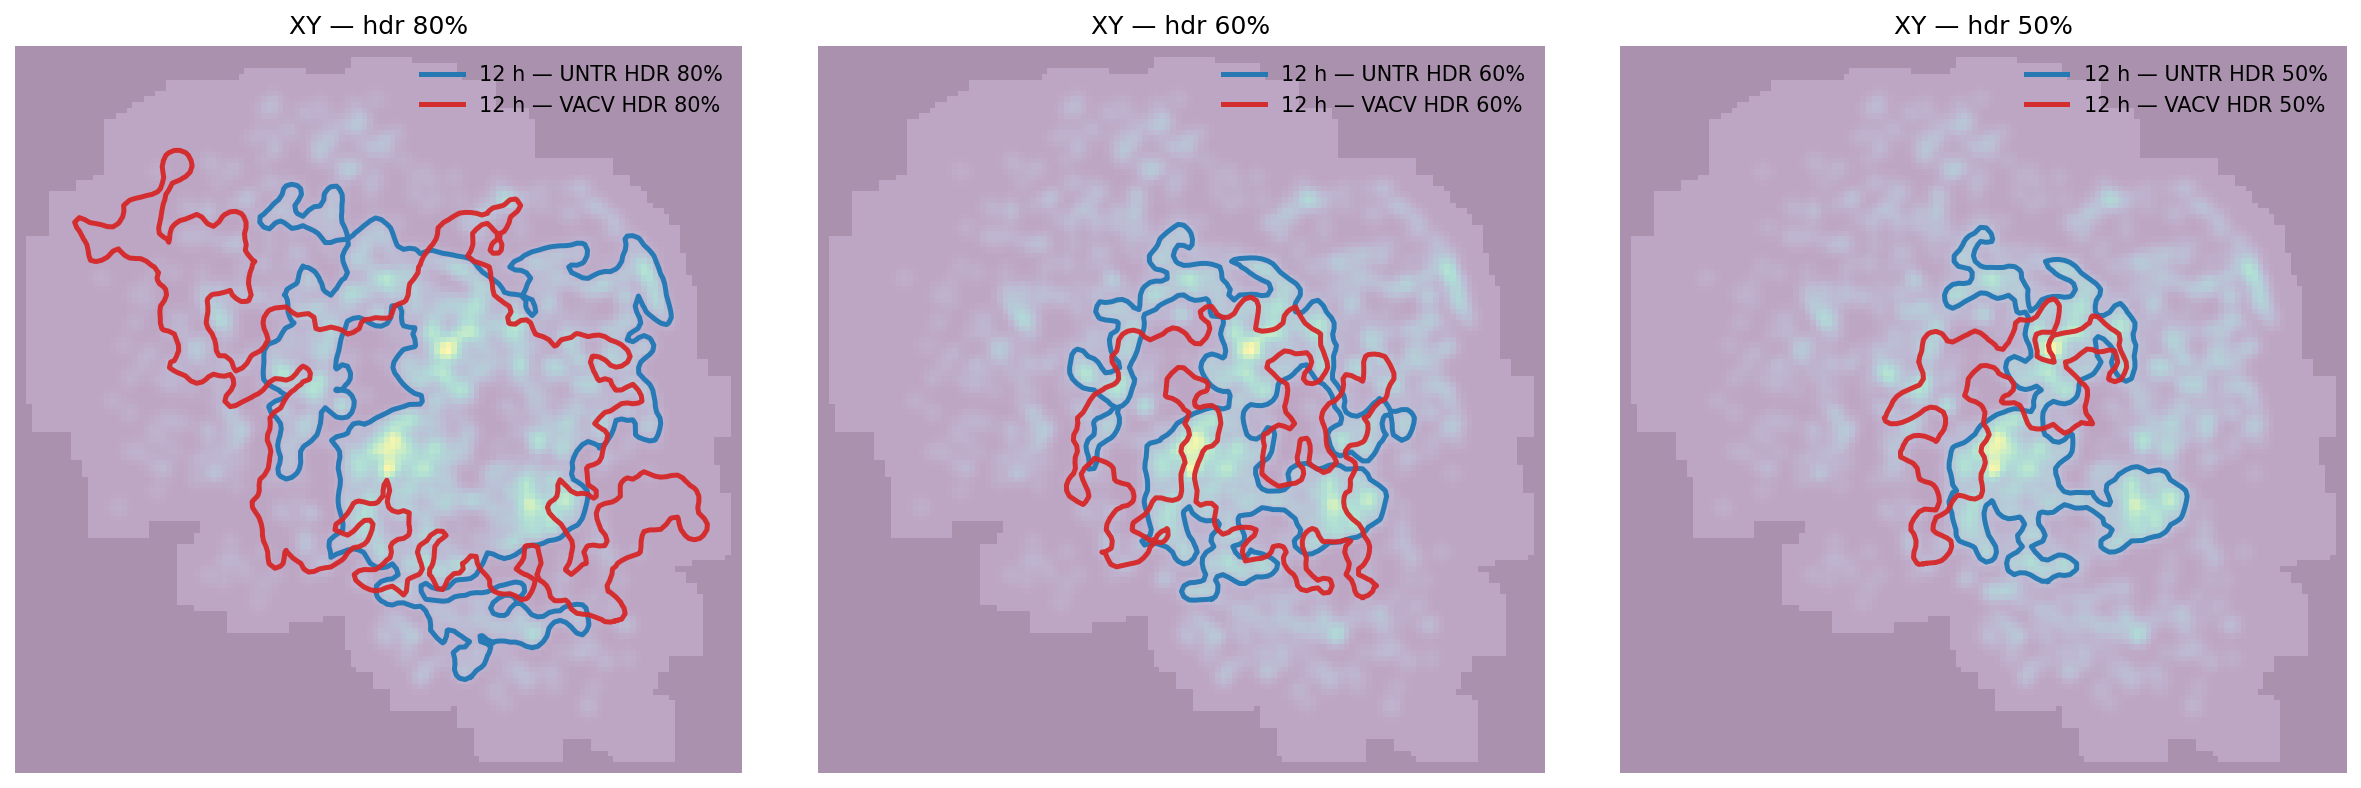

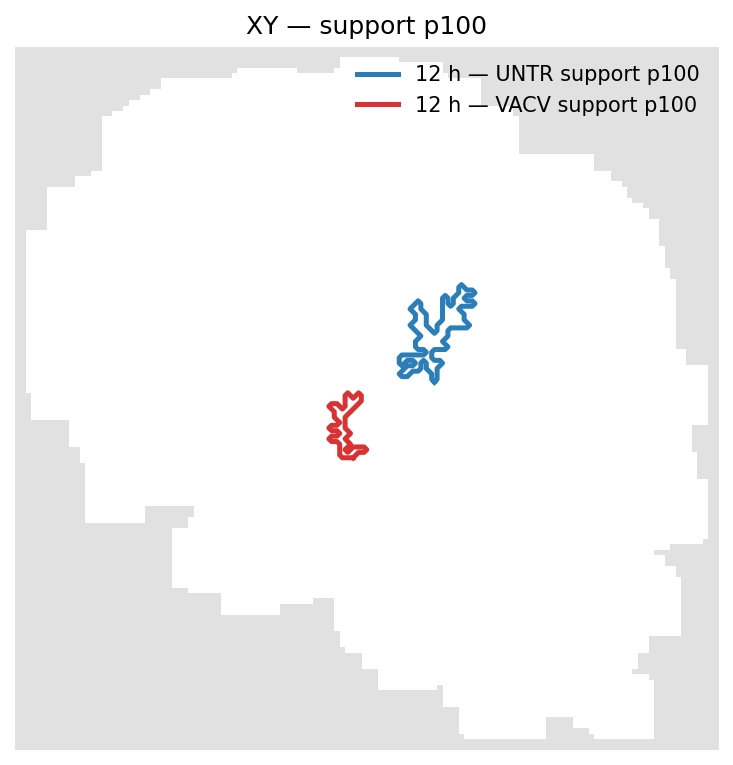

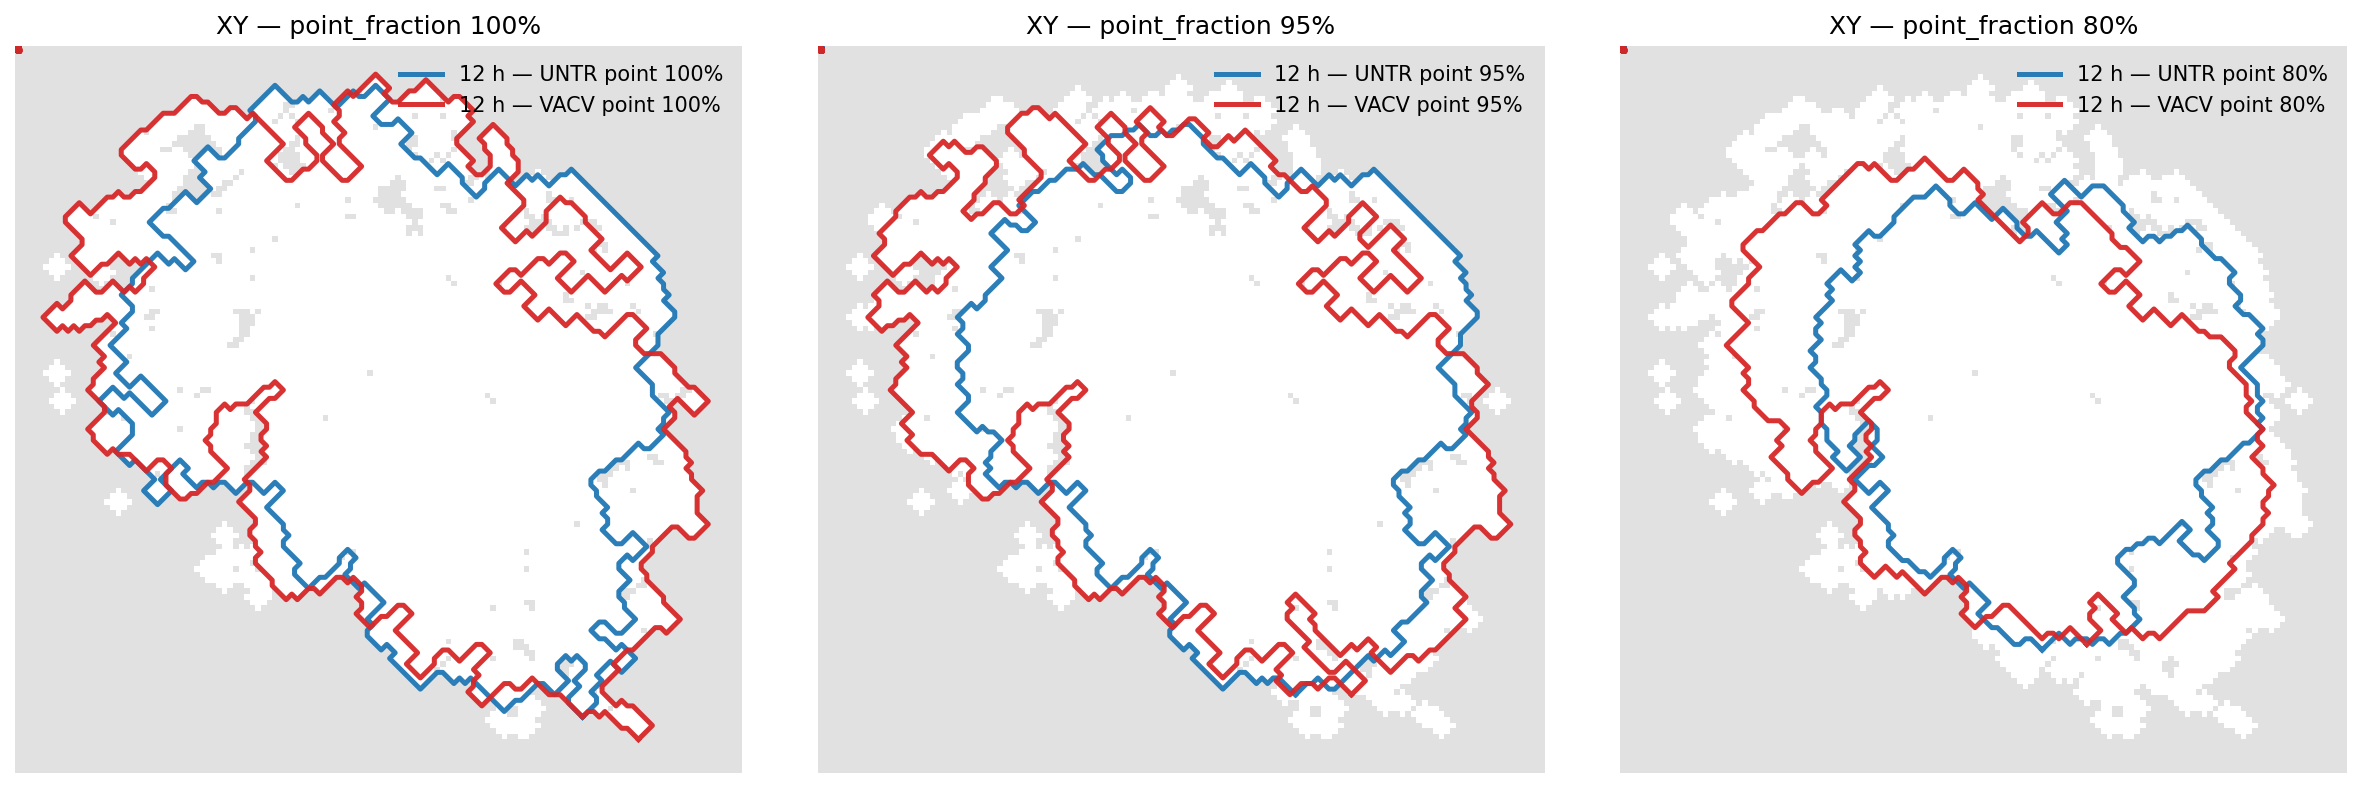

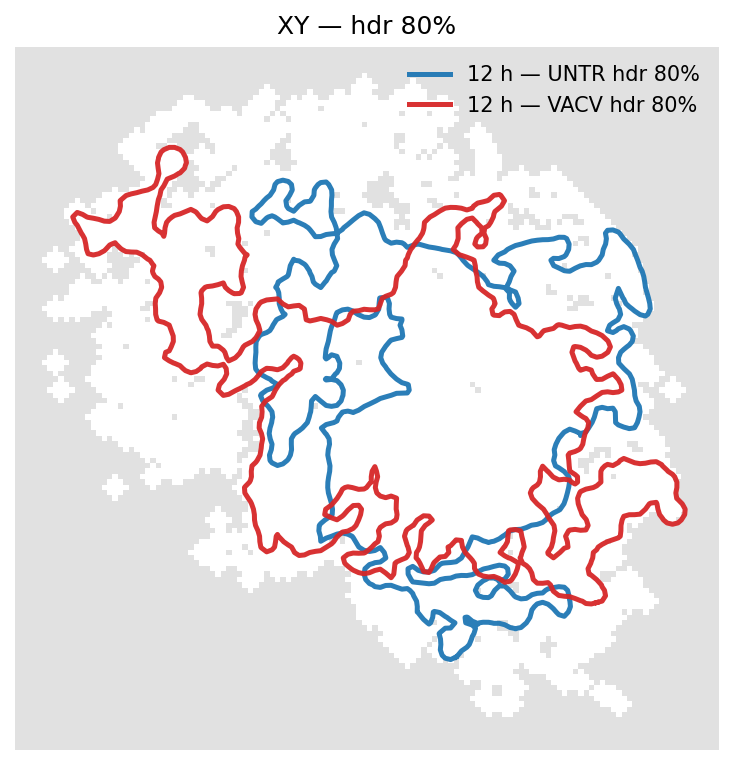

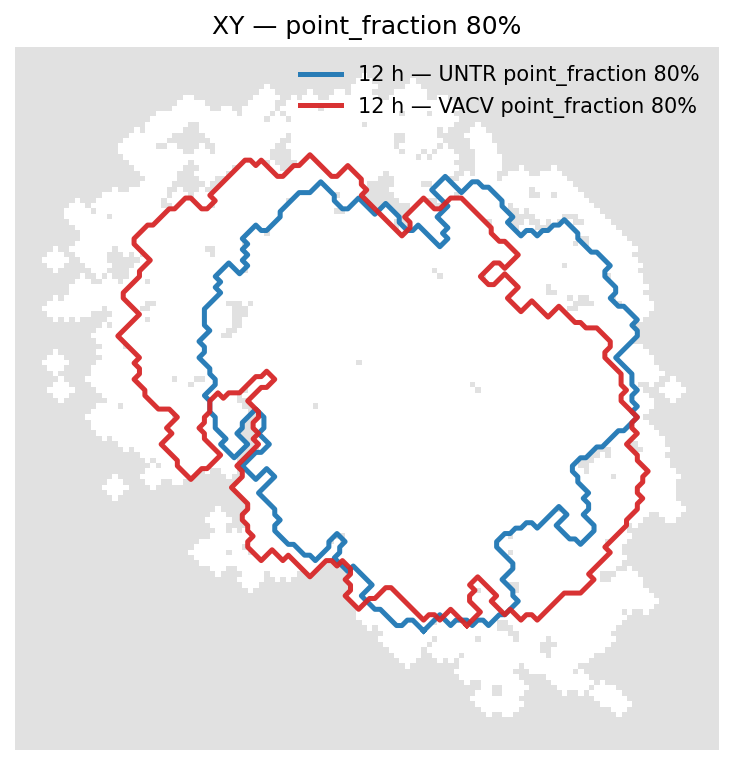

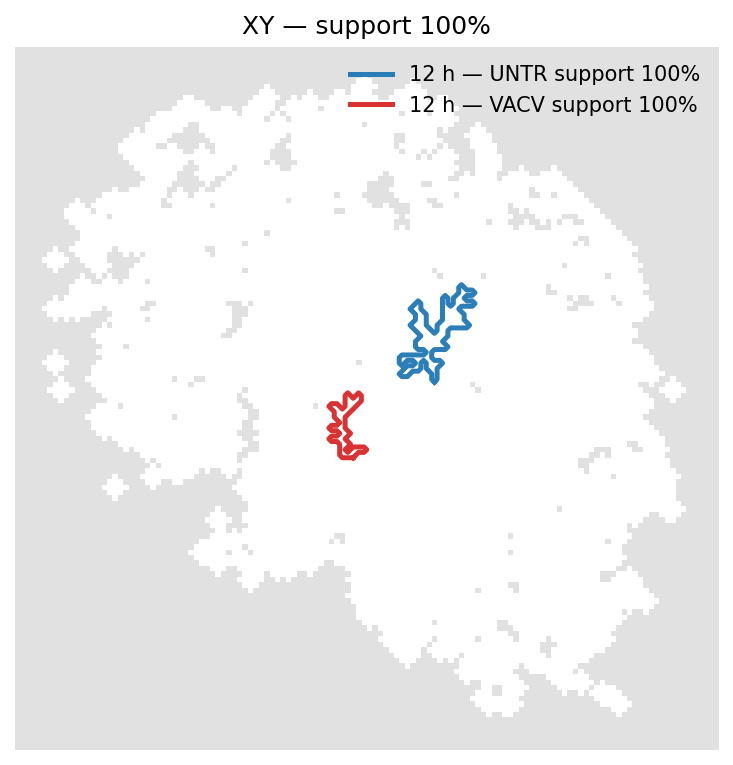

In [8]:
# ================== VISUALIZE EXTRACTED DATA (HDR + PF) ==================
# Assumes you've already run the unified pipeline cell so these exist in memory:
# - background_per_plane, DensA/DensB, SuppA/SuppB, A2d/B2d, XS/YS,
# - CFG_HDR, CFG_PF, LABEL_A, LABEL_B, CFG_COMMON, etc.

import matplotlib.pyplot as plt
import numpy as np

# -------- helpers --------
def _title(plane, variant, level):
    return f"{plane} — {variant} {level}%"

def _imshow_bg(ax, bg):
    if bg is not None:
        ax.imshow(bg, cmap="gray", alpha=0.12)

def _plot_contour(ax, C, color, label):
    if C is not None:
        ax.plot(C[:,1], C[:,0], '-', lw=2.4, color=color, alpha=0.95, label=label)

# -------- 1) HDR: show density field and p-level contours --------
def show_hdr(plane="XY", levels=(80, 60, 50), show_support=True):
    # Map plane -> axis key used in DensA/DensB dicts
    rev = {"XY":"z","YZ":"x","XZ":"y"}
    akey = rev[plane]
    D_A = DensA[akey]; D_B = DensB[akey]
    if D_A is None or D_B is None:
        print(f"[HDR] No density for {plane}"); return

    # Combine for background visualization
    D_sum = (D_A>0) | (D_B>0)
    fig, axes = plt.subplots(1, len(levels), figsize=(5.4*len(levels), 5.2))
    if len(levels)==1: axes=[axes]

    for ax, p in zip(axes, levels):
        # Compute contour + mask via the same routine used in the pipeline
        spA = make_hdr_shape(D_A, plane, p/100.0, CFG_HDR.density_floor_frac)
        spB = make_hdr_shape(D_B, plane, p/100.0, CFG_HDR.density_floor_frac)

        # show a faint density “footprint”
        ax.imshow(D_sum, cmap="gray", alpha=0.12)
        # optionally show raw density as heat
        im = ax.imshow(D_A, alpha=0.35)  # remove if you only want outlines
        _plot_contour(ax, spA['contour'], "#1f77b4", f"{LABEL_A} HDR {p}%")
        _plot_contour(ax, spB['contour'], "#d62728", f"{LABEL_B} HDR {p}%")
        ax.set_title(_title(plane, "hdr", p))
        ax.set_axis_off()
        ax.legend(frameon=False, loc="upper right")
    plt.tight_layout()
    plt.show()

    # Optional: support p100 overlay
    if show_support:
        SA = SuppA[akey]; SB = SuppB[akey]
        if SA is not None and SB is not None:
            from skimage.measure import find_contours
            def _cont(M):
                cs = find_contours(M.astype(float), 0.5); 
                cs.sort(key=lambda c: c.shape[0], reverse=True)
                return cs[0] if cs else None
            CA, CB = _cont(SA), _cont(SB)
            fig, ax = plt.subplots(figsize=(5.4, 5.2))
            _imshow_bg(ax, D_sum)
            _plot_contour(ax, CA, "#1f77b4", f"{LABEL_A} support p100")
            _plot_contour(ax, CB, "#d62728", f"{LABEL_B} support p100")
            ax.set_title(f"{plane} — support p100")
            ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
            plt.tight_layout(); plt.show()

# -------- 2) Point-Fraction: show kept-subset contours over point clouds --------
def show_point_fraction(plane="XY", levels=(100, 95, 80)):
    xs, ys = XS[plane], YS[plane]
    A2, B2 = A2d[plane], B2d[plane]
    bg = background_per_plane.get(plane)

    fig, axes = plt.subplots(1, len(levels), figsize=(5.4*len(levels), 5.2))
    if len(levels)==1: axes=[axes]

    for ax, p in zip(axes, levels):
        spA = make_pf_shape(A2, xs, ys, plane, p/100.0, CFG_PF.bandwidth, CFG_PF.disk_px)
        spB = make_pf_shape(B2, xs, ys, plane, p/100.0, CFG_PF.bandwidth, CFG_PF.disk_px)
        _imshow_bg(ax, bg)
        # (Optional) scatter points faintly:
        ax.scatter(A2[:,0], A2[:,1], s=2, alpha=0.15, c="#1f77b4")
        ax.scatter(B2[:,0], B2[:,1], s=2, alpha=0.15, c="#d62728")
        _plot_contour(ax, spA['contour'], "#1f77b4", f"{LABEL_A} point {p}%")
        _plot_contour(ax, spB['contour'], "#d62728", f"{LABEL_B} point {p}%")
        ax.set_title(_title(plane, "point_fraction", p))
        ax.set_axis_off()
        ax.legend(frameon=False, loc="upper right")
    plt.tight_layout()
    plt.show()

# -------- 3) Direct A vs B comparison at a single level & variant --------
def compare_at(plane="XY", variant="hdr", level=80):
    fig, ax = plt.subplots(figsize=(5.6,5.2))
    _imshow_bg(ax, background_per_plane.get(plane))

    if variant == "hdr":
        rev = {"XY":"z","YZ":"x","XZ":"y"}
        akey = rev[plane]
        D_A = DensA[akey]; D_B = DensB[akey]
        spA = make_hdr_shape(D_A, plane, level/100.0, CFG_HDR.density_floor_frac)
        spB = make_hdr_shape(D_B, plane, level/100.0, CFG_HDR.density_floor_frac)
    elif variant == "point_fraction":
        xs, ys = XS[plane], YS[plane]
        A2, B2 = A2d[plane], B2d[plane]
        spA = make_pf_shape(A2, xs, ys, plane, level/100.0, CFG_PF.bandwidth, CFG_PF.disk_px)
        spB = make_pf_shape(B2, xs, ys, plane, level/100.0, CFG_PF.bandwidth, CFG_PF.disk_px)
    else:  # support p100
        rev = {"XY":"z","YZ":"x","XZ":"y"}
        akey = rev[plane]
        from skimage.measure import find_contours
        def _cont(M):
            cs = find_contours(M.astype(float), 0.5); 
            cs.sort(key=lambda c: c.shape[0], reverse=True)
            return cs[0] if cs else None
        spA = dict(plane=plane, level=100, variant="support", mask=SuppA[akey], contour=_cont(SuppA[akey]))
        spB = dict(plane=plane, level=100, variant="support", mask=SuppB[akey], contour=_cont(SuppB[akey]))

    _plot_contour(ax, spA['contour'], "#1f77b4", f"{LABEL_A} {variant} {level}%")
    _plot_contour(ax, spB['contour'], "#d62728", f"{LABEL_B} {variant} {level}%")
    ax.set_title(_title(plane, variant, level))
    ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    plt.tight_layout(); plt.show()

# ================== QUICK USE ==================
show_hdr(plane="XY", levels=(80,60,50))
show_point_fraction(plane="XY", levels=(100,95,80))
compare_at(plane="XY", variant="hdr", level=80)
compare_at(plane="XY", variant="point_fraction", level=80)
compare_at(plane="XY", variant="support", level=100)